## Playground for testing the generation of personas

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "agent-storming"

In [1]:
# Reading the entire contents of a text file
def read_file_contents(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            content = file.read()
            return content
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        return None
    except PermissionError:
        print(f"Error: Permission denied to read the file '{filename}'.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


personas_filename = "../prompts/create_personas_instructions.txt"

create_personas_instructions = read_file_contents(personas_filename)
if create_personas_instructions is not None:
    print("Done reading file", personas_filename)

Done reading file ../prompts/create_personas_instructions.txt


In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

## Building the graph

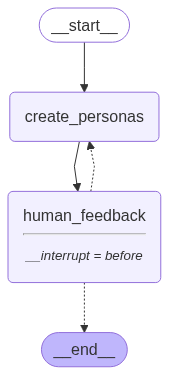

In [30]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


class Persona(BaseModel):
    name: str = Field(
        description="Name of the persona."
    )
    role: str = Field(
        description="Role of the persona in the context of the topic.",
    )
    description: str = Field(
        description="Description of the persona focus, concerns, and expertise.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    personas: List[Persona] = Field(
        description="Comprehensive list of personas with their names, roles and descriptions.",
    )

class GeneratePersonasState(TypedDict):
    topic: str # Topic of discussion
    max_personas: int # Number of personas
    human_boss_feedback: str # Human feedback
    personas: List[Persona] # experienced personas



def create_personas(state: GeneratePersonasState):
    
    """ Create personas """
    
    topic=state['topic']
    max_personas=state['max_personas']
    human_boss_feedback=state.get('human_boss_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = create_personas_instructions.format(topic=topic,
                                                         human_boss_feedback=human_boss_feedback, 
                                                         max_personas=max_personas)

    # Generate question 
    personas = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the group of experts.")])
    
    # Write the list of analysis to state
    return {"personas": personas.personas}

def human_feedback(state: GeneratePersonasState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GeneratePersonasState):
    """ Return the next node to execute """

    # Check if human feedback
    human_boss_feedback=state.get('human_boss_feedback', None)
    if human_boss_feedback:
        return "create_personas"
    
    # Otherwise end
    return END

# Add nodes and edges 
factory_builder = StateGraph(GeneratePersonasState)
factory_builder.add_node("create_personas", create_personas)
factory_builder.add_node("human_feedback", human_feedback)
factory_builder.add_edge(START, "create_personas")
factory_builder.add_edge("create_personas", "human_feedback")
factory_builder.add_conditional_edges("human_feedback", should_continue, ["create_personas", END])

# Compile
memory = MemorySaver()
personas_factory_graph = factory_builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(personas_factory_graph.get_graph(xray=1).draw_mermaid_png()))

### Inserting the topic

In [18]:
def insert_topic_in_graph(topic, max_personas, thread):
    # Run the graph until the first interruption
    for event in personas_factory_graph.stream({"topic":topic,"max_personas":max_personas,}, thread, stream_mode="values"):
        personas = event.get('personas', '')
        if personas:
            for persona in personas:
                print(f"Name: {persona.name}")
                print(f"Role: {persona.role}")
                print(f"Description: {persona.description}")
                print("-" * 50)  

### Getting human feedback

In [51]:
def get_human_feedback(thread):

    boss_feedback = input("Give your feedback, boss (Enter for ending feedback):").strip()
    if boss_feedback != "":
        personas = personas_factory_graph.get_state(thread).values.get('personas')
        personas_str = '\n'.join([persona.persona for persona in personas])
        boss_feedback = boss_feedback + "\n\n" + personas_str
        
        personas_factory_graph.update_state(thread, {"human_boss_feedback": boss_feedback}, as_node="human_feedback")
        
        # Continue the graph execution
        for event in personas_factory_graph.stream(None, thread, stream_mode="updates"):
            # Review
            personas = event.get('personas', '')
            if personas:
                for persona in personas:
                    print(f"Name: {persona.name}")
                    print(f"Role: {persona.role}")
                    print(f"Description: {persona.description}")
                    print("-" * 50) 
    print("-" * 50) 

### Get final personas

In [47]:
def continue_execution(thread):
    # Continue the graph execution to end
    personas_factory_graph.update_state(thread, {"human_boss_feedback": None}, as_node="human_feedback")
    
    personas_factory_graph.stream(None, thread, stream_mode="updates")
    
    final_state = personas_factory_graph.get_state(thread)
    personas = final_state.values.get('personas')
    print("Final state of Personas:")
    for persona in personas:
        print(f"Name: {persona.name}")
        print(f"Role: {persona.role}")
        print(f"Description: {persona.description}")
        print("-" * 50) 

## Testing the graph

In [52]:
max_personas = 3 
topic = "Discussing the architecture and system design for building an object recognition system to be deployed on an edge device"
thread = {"configurable": {"thread_id": "26"}}

insert_topic_in_graph(topic, max_personas, thread)

get_human_feedback(thread)

continue_execution(thread)

Name: Maya Rao
Role: Edge ML Architect
Description: Focuses on selecting and designing neural architectures and compression strategies that meet edge constraints. Expertise in efficient model families (MobileNet, EfficientNet-lite, YOLO-tiny), Neural Architecture Search, quantization-aware training, pruning, knowledge distillation, and mixed-precision techniques. Primary concerns are accuracy vs. latency/memory trade-offs, maintaining robustness after compression, and integration with edge runtimes (TensorFlow Lite, ONNX Runtime, TVM). She evaluates performance using realistic benchmarks (FPS, p50/p95 latency, peak memory, energy per inference) and guides model-to-runtime translation.
--------------------------------------------------
Name: Luca Bianchi
Role: Embedded Systems & Hardware Integration Engineer
Description: Responsible for selecting edge hardware and integrating the full perception pipeline into the device. Deep experience with SoCs (ARM Cortex, NPUs, GPUs), accelerators (

Give your feedback, boss (Enter for ending feedback): replace the data scientist with a sales engineer.


--------------------------------------------------
Final state of Personas:
Name: Maya Rao
Role: Edge ML Architect
Description: Theme: Model architecture, compression, and accuracy-vs-latency trade-offs. Focuses on selecting and designing neural architectures and compression strategies that meet edge constraints. Expertise in efficient model families (MobileNet, EfficientNet-lite, YOLO-tiny), Neural Architecture Search, quantization-aware training, pruning, knowledge distillation, and mixed-precision techniques. Primary concerns are accuracy vs. latency/memory trade-offs, maintaining robustness after compression, and integration with edge runtimes (TensorFlow Lite, ONNX Runtime, TVM). Evaluates performance using realistic benchmarks (FPS, p50/p95 latency, peak memory, energy per inference) and guides model-to-runtime translation.
--------------------------------------------------
Name: Luca Bianchi
Role: Embedded Systems & Hardware Integration Engineer
Description: Theme: Hardware sele

In [54]:
max_personas = 3 
topic = "Choosing which cloud platform between AWS, Azure, and GCP to deploy our deep learning models that work with large-scale data input."
thread = {"configurable": {"thread_id": "24"}}

insert_topic_in_graph(topic, max_personas, thread)

get_human_feedback(thread)

continue_execution(thread)

Name: Ravi Patel
Role: Infrastructure Performance Engineer
Description: Focuses on raw training and inference performance: accelerator choices (NVIDIA A100/H100, Google TPUs, AWS Trainium/Inferentia), multi-node scaling, interconnect (RDMA/EFA), network topology, and storage I/O throughput. Measures and optimizes end-to-end throughput and latency for distributed training (Horovod, PyTorch DDP, TensorFlow), tuning mixed precision, batch sizes and checkpointing to minimize wall-clock time. Concerns include maximizing GPU/TPU utilization, reducing communication overhead, avoiding storage or network bottlenecks during large-scale data ingest, and producing reproducible benchmark data to compare AWS/Azure/GCP offerings.
--------------------------------------------------
Name: Elena García
Role: Data Engineering & Storage Architect
Description: Designs scalable, cost-effective data pipelines and storage for very large training datasets: ingestion (streaming and batch), partitioning, compress

Give your feedback, boss (Enter for ending feedback): 


--------------------------------------------------
Final state of Personas:
Name: Ravi Patel
Role: Infrastructure Performance Engineer
Description: Focuses on raw training and inference performance: accelerator choices (NVIDIA A100/H100, Google TPUs, AWS Trainium/Inferentia), multi-node scaling, interconnect (RDMA/EFA), network topology, and storage I/O throughput. Measures and optimizes end-to-end throughput and latency for distributed training (Horovod, PyTorch DDP, TensorFlow), tuning mixed precision, batch sizes and checkpointing to minimize wall-clock time. Concerns include maximizing GPU/TPU utilization, reducing communication overhead, avoiding storage or network bottlenecks during large-scale data ingest, and producing reproducible benchmark data to compare AWS/Azure/GCP offerings.
--------------------------------------------------
Name: Elena García
Role: Data Engineering & Storage Architect
Description: Designs scalable, cost-effective data pipelines and storage for very larg

In [57]:
max_personas = 5 
topic = "Who did really build the pyramids and how were they built?"
thread = {"configurable": {"thread_id": "32"}}

insert_topic_in_graph(topic, max_personas, thread)

get_human_feedback(thread)

continue_execution(thread)

Name: Dr. Layla Hassan
Role: Egyptologist and Archaeological Historian
Description: Focuses on the historical and textual evidence for pyramid construction, including inscriptions, tomb reliefs and administrative records. Emphasizes the consensus that the pyramids were built by ancient Egyptians under state organization, interprets funerary purpose and religious context, and integrates recent finds such as the Merer papyri and the Giza workers' town into that narrative.
--------------------------------------------------
Name: Prof. Marco Bellini
Role: Architectural Engineer (Ancient Construction Specialist)
Description: Analyzes structural design, construction methods and engineering logistics: ramp hypotheses (straight, zigzag, spiral), levering systems, stone dressing and placement accuracy. Draws on experimental archaeology, engineering models and material-science evidence to evaluate how heavy blocks could be moved, lifted and set with Bronze Age technology.
-----------------------

Give your feedback, boss (Enter for ending feedback): 


--------------------------------------------------
Final state of Personas:
Name: Dr. Layla Hassan
Role: Egyptologist and Archaeological Historian
Description: Focuses on the historical and textual evidence for pyramid construction, including inscriptions, tomb reliefs and administrative records. Emphasizes the consensus that the pyramids were built by ancient Egyptians under state organization, interprets funerary purpose and religious context, and integrates recent finds such as the Merer papyri and the Giza workers' town into that narrative.
--------------------------------------------------
Name: Prof. Marco Bellini
Role: Architectural Engineer (Ancient Construction Specialist)
Description: Analyzes structural design, construction methods and engineering logistics: ramp hypotheses (straight, zigzag, spiral), levering systems, stone dressing and placement accuracy. Draws on experimental archaeology, engineering models and material-science evidence to evaluate how heavy blocks could 